# EE 5614 – Learning for Dynamics & Control `(L4DC)`

In [ ]:
import random


import numpy                as np
import matplotlib.pyplot    as plt
import numpy                as np
import matplotlib.pyplot    as plt
import tensorflow           as tf

from tensorflow             import keras
from scipy.integrate        import solve_ivp

np.random.seed(45)
random.seed(45)


## Part 1: Extended Dynamic Mode Decomposition (e-DMD)

#### In the `dictionary` function, try changing the basis functions. I have produced results by choosing the basis functions that seems to be the minimally best choice given the structure of the differential equations of Lotka-Voltera Model.

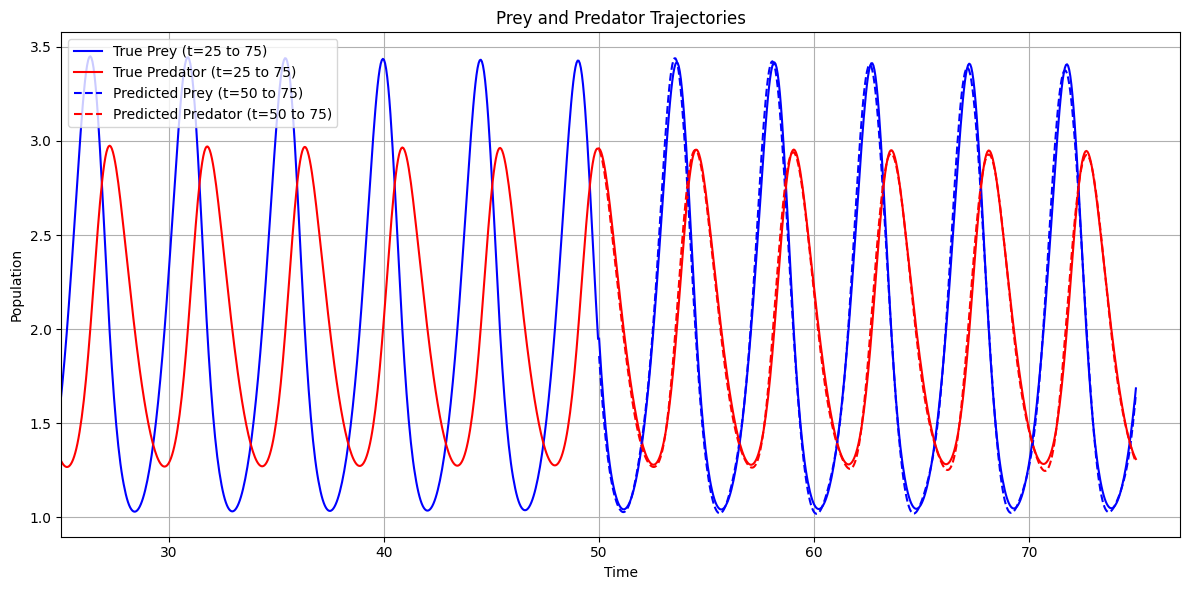

In [ ]:

# 1. Define Lotka-Volterra Dynamics
def lotka_volterra(t, x, alpha, beta, gamma, delta, u):
    x1, x2 = x
    dx1dt = alpha * x1 - beta * x1 * x2 + x1 * u
    dx2dt = -gamma * x2 + delta * x1 * x2
    return [dx1dt, dx2dt]

# Parameters
alpha, beta, gamma, delta = 2.0, 1.0, 1.0, 0.5
u = 0

x0 = [2, 3]
t_span_train = (0, 50)
dt = 0.05
t_eval_train = np.arange(t_span_train[0], t_span_train[1], dt)

# Simulating training data
sol_train = solve_ivp(lotka_volterra, t_span_train, x0, args=(alpha, beta, gamma, delta, u), t_eval=t_eval_train)
X_train = sol_train.y.T
t_train = sol_train.t

# 2. Defining the Dictionary
# Addition of functions makes the prediction better
# Change the functions yourself.
def dictionary(X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    return np.column_stack([
        np.ones_like(x1),
        x1, x2,
        x1**2, x2**2, x1 * x2,
        # np.sinc(x1), np.sinc(x2),
        np.sin(x1), np.sin(x2),
        # np.exp(x1), np.exp(x2),
        # np.tanh(x1), np.tanh(x2),
        # np.sinh(x1), np.sinh(x2),
        # np.log(x1), np.log(x2),
        # np.cos(x1), np.cos(x2),
    ])

# Constructing Koopman Operator
Phi_X = dictionary(X_train[:-1])
Phi_Y = dictionary(X_train[1:])
K = Phi_Y.T @ np.linalg.pinv(Phi_X.T)

#Predicting Future States
n_steps_predict = int((75 - 50) / dt)
last_true_state = X_train[-1].reshape(1, -1)
phi_last = dictionary(last_true_state)

predicted = []
phi = phi_last.T

for _ in range(n_steps_predict):
    phi = K @ phi
    x1_hat = phi[1, 0]
    x2_hat = phi[2, 0]
    predicted.append([x1_hat, x2_hat])

X_predicted = np.array(predicted)
t_pred = np.arange(t_train[-1] + dt, t_train[-1] + (n_steps_predict + 1) * dt, dt)

# Real trajectories
t_span_future = (t_pred[0], t_pred[-1])
sol_future = solve_ivp(
    lotka_volterra,
    t_span_future,
    X_train[-1],
    args=(alpha, beta, gamma, delta, u),
    t_eval=t_pred
)
X_true_future = sol_future.y.T

# Plotting
plt.figure(figsize=(12, 6))

start_plot_index = int(20 / dt)
end_train_index = len(t_train)
plt.plot(t_train[start_plot_index:end_train_index], X_train[start_plot_index:end_train_index, 0], 'b-')
plt.plot(t_train[start_plot_index:end_train_index], X_train[start_plot_index:end_train_index, 1], 'r-')

plt.plot(t_pred, X_true_future[:, 0], 'b-', label='True Prey (t=25 to 75)')
plt.plot(t_pred, X_true_future[:, 1], 'r-', label='True Predator (t=25 to 75)')

plt.plot(t_pred, X_predicted[:, 0], 'b--', label='Predicted Prey (t=50 to 75)')
plt.plot(t_pred, X_predicted[:, 1], 'r--', label='Predicted Predator (t=50 to 75)')

plt.title("Prey and Predator Trajectories")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.xlim(25, 77)
plt.tight_layout()
plt.show()

In [8]:
# If the eigenvalues of the koopman operator lie on the unit circle then oscillatory behavior, if inside the unit circle then stable, if outside the unit circle then unstable

eigenvalues, eigenvectors = np.linalg.eig(K)
print(np.abs(eigenvalues))

[0.99702751 0.99702751 0.99971171 0.99971171 0.99998722 0.99998722
 0.96101744 1.        ]


#### Note that the eigenvalues of the learned Koopman operator lies very close to the boundry of the unit circle, which indicates the oscillary behavior given this initial condition.

## Part 2: Deep Dynamic Mode Decomposition (d-DMD)

#### We've made an autoencoder with high-dimensional latent space. The encoder works as the `lifting` to the high dimensional (ideally infitie-dimensional) Koopman space. The latent space is the koopman space (approximation), and the decoder is the `un-lifing` to the dynamical space that we have. 

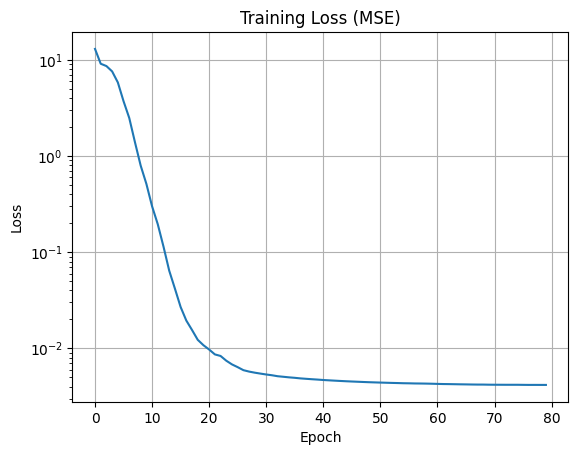

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


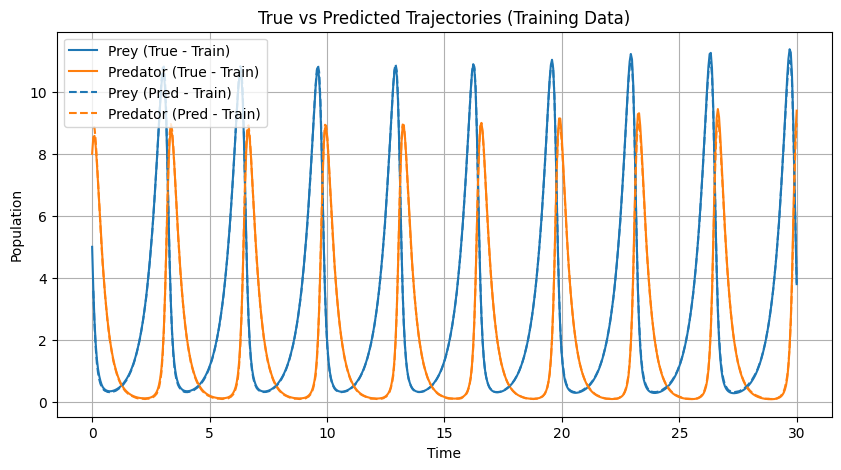

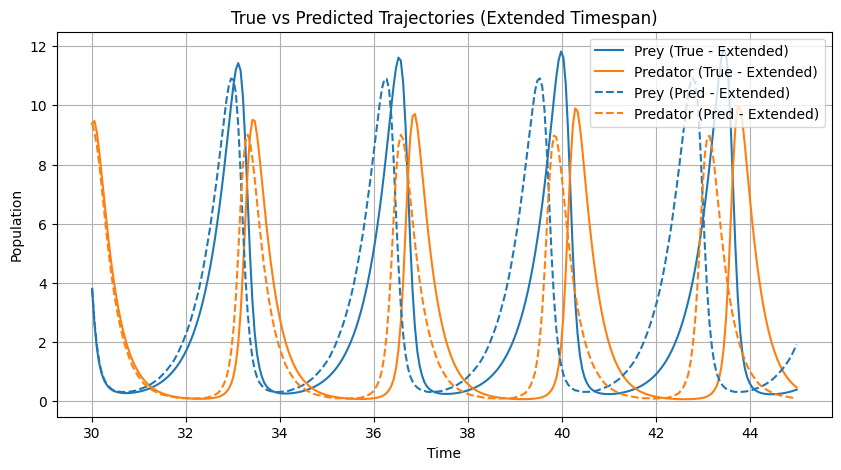

In [ ]:
def lotka_volterra(t, z, alpha, beta, delta, gamma):
    x, y = z
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Data Generatation
t_span_train = (0, 30)
t_eval_train = np.linspace(*t_span_train, 600)
z0_train = [5, 8]
params = (2.0, 1.0, 1.0, 3.0)
sol_train = solve_ivp(lotka_volterra, t_span_train, z0_train, args=params, t_eval=t_eval_train)
X_true_train = sol_train.y.T
t_train = sol_train.t

# Training data
X_train = X_true_train[:-1]
Y_train = X_true_train[1:]

# Defining Encoder
encoder_input = keras.Input(shape=(2,))
x = keras.layers.Dense(64, activation='relu')(encoder_input)
x = keras.layers.Dense(128, activation='sigmoid')(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(32, activation='tanh')(x)
encoded = keras.layers.Dense(25)(x)

# Koopman layer (linear dynamics in latent space)
koopman = keras.layers.Dense(25, use_bias=False, name="koopman")(encoded)

# Decoder with corresponding dimensions
x = keras.layers.Dense(32, activation='relu')(koopman)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(64, activation='tanh')(x)
decoded = keras.layers.Dense(2)(x)

deepdmd_model = keras.Model(inputs=encoder_input, outputs=decoded)

deepdmd_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')

# Convert training data to tensors
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train_tf = tf.convert_to_tensor(Y_train, dtype=tf.float32)

# Train model for more epochs
history = deepdmd_model.fit(X_train_tf, Y_train_tf, batch_size=100, epochs=80, verbose=0)

# Plot training loss
plt.plot(history.history['loss'])
plt.yscale('log')
plt.title("Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Predict the next state for each point in X_train
X_predicted_train = deepdmd_model.predict(X_train_tf)

# Plot predictions vs true trajectories (training data)
plt.figure(figsize=(10, 5))
plt.plot(t_train, X_true_train[:, 0], label='Prey (True - Train)', color='tab:blue')
plt.plot(t_train, X_true_train[:, 1], label='Predator (True - Train)', color='tab:orange')
plt.plot(t_train[1:], X_predicted_train[:, 0], '--', label='Prey (Pred - Train)', color='tab:blue')
plt.plot(t_train[1:], X_predicted_train[:, 1], '--', label='Predator (Pred - Train)', color='tab:orange')
plt.title("True vs Predicted Trajectories (Training Data)")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.show()

# Generate new data after the training timespan
t_start_predict = t_train[-1]
t_end_predict = t_start_predict + 15
num_points_predict = 300
t_eval_predict = np.linspace(t_start_predict, t_end_predict, num_points_predict)
z0_predict = X_true_train[-1]
sol_predict = solve_ivp(lotka_volterra, (t_start_predict, t_end_predict), z0_predict, args=params, t_eval=t_eval_predict)
X_true_predict = sol_predict.y.T
t_predict = sol_predict.t

# Make predictions on the newly generated data
X_predicted_extended = np.zeros_like(X_true_predict)
current_state = tf.convert_to_tensor(X_true_train[-1].reshape(1, -1), dtype=tf.float32)
X_predicted_extended[0] = current_state.numpy()

for i in range(1, num_points_predict):
    next_state = deepdmd_model.predict(current_state, verbose=0)
    X_predicted_extended[i] = next_state.flatten()
    current_state = next_state

# Plot the predicted trajectory against the true trajectory
plt.figure(figsize=(10, 5))
plt.plot(t_predict, X_true_predict[:, 0], label='Prey (True - Extended)', color='tab:blue')
plt.plot(t_predict, X_true_predict[:, 1], label='Predator (True - Extended)', color='tab:orange')
plt.plot(t_predict, X_predicted_extended[:, 0], '--', label='Prey (Pred - Extended)', color='tab:blue')
plt.plot(t_predict, X_predicted_extended[:, 1], '--', label='Predator (Pred - Extended)', color='tab:orange')
plt.title("True vs Predicted Trajectories (Extended Timespan)")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
koopman_matrix = deepdmd_model.get_layer("koopman").get_weights()[0]
eigs = np.linalg.eigvals(koopman_matrix)
print("Magnitude of the eigenvalues of the Koopman operator:")
print(np.abs(eigs))

Magnitude of the eigenvalues of the Koopman operator:
[1.1319185  1.1319185  0.96139586 0.96139586 0.9678543  0.8849771
 0.8849771  0.8119177  0.8119177  0.7187294  0.7187294  0.59178454
 0.59178454 0.35560694 0.45146233 0.45146233 0.73748153 0.73748153
 0.68904364 0.68904364 0.39380428 0.39380428 0.3865246  0.2206719
 0.2206719 ]
